In [1]:
import os

import warnings
warnings.filterwarnings('ignore') # suppress future warnings of conflict between pandas and xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# import cv
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score

# import shap
import shap

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

# Configure parameter setting
1. Users are required to setup path to the cleaned data set.\

In [2]:
ROOT = os.getcwd()

# setup input parameters for modeling
params = {}
params['input file name'] = os.path.join(ROOT + '/irae_combined_cleaned.csv')

# Define Machine Learning Parameters

In [3]:
# define cross-validation (cv) parameters
params['seed'] = 0
params['cv_fold'] = 10
params['eval_metric'] = 'roc_auc'
params['n_jobs'] = -1

# Define Function For Displaying Formatted P-Value

In [4]:
def latex_p(p):
    if p < 0.001:
        output = str('(p<$\mathregular{10^{%1.0f}}$)' % (0.5 + np.log10(p)))
    elif p < 0.01:
        output = str('(p<0.01)')
    elif p < 0.05:
        output = str('(p<0.05)')
    else:
        output = str('(p=%0.2f)' % p)
    return output

# Import Data and Select Features

In [5]:
# read data from input file
input_data = pd.read_csv(params['input file name'])

In [6]:
input_data.head()

,Sex,Race,Age_at_diagnosis,Histology,Stage,Smoking,Immunotherapy_Class,TKI+,PD_L1_Range,Time_to_irAE,...,irAE_early,irAE_late,irAE_category_IRAE,EGFR,KRAS,ALK,ROS1,BRAF,MET,RET
0,Female,NaN,65,adenocarcinoma,4.0,non-smoker,anti-pd-1,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,Male,White,85,adenocarcinoma,4.0,smoker,anti-pd-l1,0,NaN,1.0,...,1,0,1,0,1,0,0,0,0,0
2,Male,Asian,61,adenocarcinoma,4.0,smoker,anti-pd-1,0,>=50%,62.0,...,1,0,1,0,1,0,0,0,0,0
3,Female,Black or African American,66,other,4.0,smoker,anti-pd-l1,0,1-49%,NaN,...,0,0,0,0,0,1,0,0,0,0
4,Male,NaN,63,adenocarcinoma,4.0,smoker,anti-pd-1,0,>=50%,167.0,...,0,1,1,0,0,0,0,0,0,0


In [7]:
# drop unused features
drop_list = ['Sex', 'Race', 'Histology', 'Smoking', 'Immunotherapy_Class', 'TKI+', 'PD_L1_Range',
             'irAE_EarlyLate', 'irAE_category', 'PD_L1_Range_Positive', 'irAE_late',
             'EGFR', 'KRAS', 'ALK', 'ROS1', 'BRAF', 'MET', 'RET']
input_data.drop(columns=drop_list, inplace=True)

In [8]:
# check input data again
input_data.head()

,Age_at_diagnosis,Stage,Time_to_irAE,isDeceased,os_days,os_1yr_isDeceased,isProgressed,pfs_days,pfs_6months_isProgressed,label,...,Histology_squamous,Smoker+,ImClass_anti-pd-l1,ImClass_anti-pd-1,PD_L1_Range_>=50%,PD_L1_Range_1-49%,PD_L1_Range_Negative,irAE+,irAE_early,irAE_category_IRAE
0,65,4.0,NaN,1,42,1,1,42.0,1,train,...,0,0,0,1,0,0,0,0,0,0
1,85,4.0,1.0,1,231,1,1,97.0,1,train,...,0,1,1,0,0,0,0,1,1,1
2,61,4.0,62.0,1,642,0,1,168.0,1,train,...,0,1,0,1,1,0,0,1,1,1
3,66,4.0,NaN,0,91,1,1,88.0,1,train,...,0,1,1,0,0,1,0,0,0,0
4,63,4.0,167.0,1,328,1,1,328.0,0,train,...,0,1,0,1,1,0,0,1,0,1


# Filter irAE-related features
For predicting OS after 1 year or PFS after 6 months, it does not make sense to utilize irAE-related information if irAE occurred after 1 year (for os) or 6 months (for pfs)

In [9]:
# if time to irae > 6 months , then irae-related variables should be set to 0
time_threshold = 180

input_data.loc[input_data['Time_to_irAE']>time_threshold, 'irAE+'] = 0
input_data.loc[input_data['Time_to_irAE']>time_threshold, 'irAE_early'] = 0
input_data.loc[input_data['Time_to_irAE']>time_threshold, 'irAE_category_IRAE'] = 0

input_data.drop(columns='Time_to_irAE', inplace=True)

# Prepare Training, Validation, and Testing Data
Among the 354 patients, 283 (80%) patients were used as training data and 71 (20%) patients were used as testing data
10-fold cross-validation was applied to the training data for tuning hyperparameters

In [10]:
# setting up X and y for training
y = input_data[['isProgressed', 'pfs_days', 'pfs_6months_isProgressed']].copy()

# convert deceased to survived
y['surv_getThres'] = 1 - y['pfs_6months_isProgressed']
y.drop(columns=["pfs_6months_isProgressed"], inplace=True)

# convert os_days to months
y['pfs_days'] = round(y['pfs_days'] / 30.0)
y['pfs_days'] = y['pfs_days'].fillna(0)
y.rename(columns={"pfs_days": "surv_months"}, inplace=True)

# define isDeceased as surv_event
y.rename(columns={"isProgressed": "surv_event"}, inplace=True)

# extract label
data_label = input_data['label'].copy()

# drop unused features
X = input_data.drop(columns=['os_1yr_isDeceased', 'pfs_6months_isProgressed', 'os_days', 'pfs_days', 'isDeceased', 'isProgressed', 'label'], axis=1)
X = X.fillna(0)

# assign training (80%) and testing (20%) data
X_full_train, y_full_train = X.loc[data_label=='train', :], y.loc[data_label=='train', :]
X_test, y_test = X.loc[data_label=='test', :], y.loc[data_label=='test', :]

In [11]:
X_full_train.head()

,Age_at_diagnosis,Stage,Prior_TKI+,Sex_Male,Race_White,Race_Asian,Race_Black,Histology_adenocarcinoma,Histology_squamous,Smoker+,ImClass_anti-pd-l1,ImClass_anti-pd-1,PD_L1_Range_>=50%,PD_L1_Range_1-49%,PD_L1_Range_Negative,irAE+,irAE_early,irAE_category_IRAE
0,65,4.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,85,4.0,0,1,1,0,0,1,0,1,1,0,0,0,0,1,1,1
2,61,4.0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,1,1
3,66,4.0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0
4,63,4.0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1


In [12]:
y_full_train.head()

,surv_event,surv_months,surv_getThres
0,1,1.0,0
1,1,3.0,0
2,1,6.0,0
3,1,3.0,0
4,1,11.0,1


In [13]:
def latex_p(p):
    if p < 0.001:
        output = str('(p<$\mathregular{10^{%1.0f}}$)' % (0.5 + np.log10(p)))
    elif p < 0.01:
        output = str('(p<0.01)')
    elif p < 0.05:
        output = str('(p<0.05)')
    else:
        output = str('(p=%0.2f)' % p)
    return output

# Logistic Regression without Regularization

In [14]:
#train
lr_estimator = LogisticRegression(penalty='none')
lr_estimator.fit(X_full_train, y_full_train['surv_getThres'])

LogisticRegression(penalty='none')

In [15]:
# prediction
lr_prediction = lr_estimator.predict_proba(X_test)[:, 1].tolist()

# compute tpr, fpr, and auc
lr_fpr, lr_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(lr_prediction))
lr_roc_auc = auc(lr_fpr, lr_tpr)
print('ROC AUC for simple logistic regression is ' + str(round(lr_roc_auc, 4)))

ROC AUC for simple logistic regression is 0.6402


# Logistic Regression with Elastic Net Regularization

In [42]:
std_scaler = StandardScaler()
elr = LogisticRegression(penalty='elasticnet', random_state=params['seed'], solver='saga', max_iter=10000)
elr_pipe = Pipeline(steps=[('std_scaler', std_scaler), ('lr', elr)])

# setup CV parameter space
elr_cv_params = {'lr__fit_intercept': [True, False], 'lr__class_weight': ['None', 'balanced'],
                 'lr__l1_ratio': sp_uniform(0, 1), 'lr__C': sp_uniform(10 ** -1, 10 ** 3 - 10 ** -1)}

# run randomized search CV
elr_estimator_search = RandomizedSearchCV(elr_pipe,
                                          param_distributions=elr_cv_params,
                                          scoring=params['eval_metric'],
                                          n_iter=1000,
                                          cv=params['cv_fold'],
                                          random_state=params['seed'],
                                          n_jobs=-1,
                                          verbose=0)

elr_estimator_search.fit(X_full_train, y_full_train['surv_getThres'])
elr_estimator = elr_estimator_search.best_estimator_

elr_estimator_search.best_params_

{'lr__C': 1.0031951926975056,
 'lr__class_weight': 'balanced',
 'lr__fit_intercept': False,
 'lr__l1_ratio': 0.22649127794102164}

In [44]:
# train on best estimator
elr_estimator.fit(X_full_train, y_full_train['surv_getThres'])

# prediction
elr_prediction = elr_estimator.predict_proba(X_test)[:, 1].tolist()

# compute tpr, fpr, and auc
elr_fpr, elr_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(elr_prediction))
elr_roc_auc = auc(elr_fpr, elr_tpr)
print('ROC AUC for elasticnet logistic regression is ' + str(round(elr_roc_auc, 4)))

ROC AUC for elasticnet logistic regression is 0.6479


# XGBoost

In [47]:
# setup CV parameter space
xgb_cv_params = {'learning_rate': [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
                 'min_child_weight': [1, 3, 5, 7],
                 'gamma': [0.1, 0.2, 0.3, 0.4],
                 'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
                 'n_estimators': [100, 300, 500]}

# setup initial parameters
xgb_init_params = {'n_estimators': 173, 'random_state': params['seed'], 'learning_rate': .1,
                   'reg_alpha': 1, 'reg_lambda': 1, 'eval_metric': 'logloss'}

# run randomized search CV
xgb_estimator_search = RandomizedSearchCV(xgb.XGBClassifier(**xgb_init_params),
                                          param_distributions=xgb_cv_params,
                                          n_iter=500,
                                          scoring=params['eval_metric'],
                                          cv=params['cv_fold'],
                                          random_state=params['seed'],
                                          verbose=0)

xgb_estimator_search.fit(X_full_train, y_full_train['surv_getThres'])
xgb_estimator = xgb_estimator_search.best_estimator_

xgb_estimator_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [48]:
# train on best estimator
xgb_estimator.fit(X_full_train, y_full_train['surv_getThres'])

# prediction
xgb_prediction = xgb_estimator.predict_proba(X_test)[:, 1].tolist()

# compute tpr, fpr, and auc
xgb_fpr, xgb_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(xgb_prediction))
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
print('ROC AUC for XGBoost is ' + str(round(xgb_roc_auc, 4)))

ROC AUC for XGBoost is 0.6513


# Light GBM

In [50]:
# setup CV parameter space
lgbm_cv_params = {'learning_rate': [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                  'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
                  'min_child_weight': [1, 3, 5, 7],
                  'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
                  'n_estimators': [100, 300, 500]}

# setup initial parameters
lgbm_init_params = {'n_estimators': 173, 'random_state': params['seed'], 'learning_rate': .1, 'reg_alpha': 1, 'reg_lambda': 1}

# run randomized search CV
lgbm_estimator_search = RandomizedSearchCV(lgb.LGBMClassifier(**lgbm_init_params),
                                           param_distributions=lgbm_cv_params,
                                           n_iter=500,
                                           scoring=params['eval_metric'],
                                           cv=params['cv_fold'],
                                           random_state=params['seed'],
                                           verbose=0)

lgbm_estimator_search.fit(X_full_train, y_full_train['surv_getThres'])
lgbm_estimator = lgbm_estimator_search.best_estimator_

lgbm_estimator_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.2,
 'colsample_bytree': 0.3}

In [51]:
# train on best estimator
lgbm_estimator.fit(X_full_train, y_full_train['surv_getThres'])

# prediction
lgbm_prediction = lgbm_estimator.predict_proba(X_test)[:, 1].tolist()

# compute tpr, fpr, and auc
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(lgbm_prediction))
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)
print('ROC AUC for LightGBM is ' + str(round(lgbm_roc_auc, 4)))

ROC AUC for LightGBM is 0.635


# CatBoost

In [53]:
# setup CV parameter space
catb_cv_params = {'depth': sp_randint(3, 7), 'learning_rate': sp_uniform(0.01, 0.9),
                  'iterations': sp_randint(10, 100), 'l2_leaf_reg': sp_randint(1, 100)}

# run randomized search CV
catb_estimator_search = RandomizedSearchCV(CatBoostClassifier(verbose=0, allow_writing_files=False),
                                         param_distributions=catb_cv_params,
                                         n_iter=500,
                                         scoring=params['eval_metric'],
                                         cv=params['cv_fold'],
                                         random_state=params['seed'],
                                         verbose=0)

catb_estimator_search.fit(X_full_train, y_full_train['surv_getThres'])
catb_estimator = catb_estimator_search.best_estimator_

catb_estimator_search.best_params_

{'depth': 5,
 'iterations': 70,
 'l2_leaf_reg': 17,
 'learning_rate': 0.2185314638240841}

In [54]:
# train on best estimator
catb_estimator.fit(X_full_train, y_full_train['surv_getThres'])

# prediction
catb_prediction = catb_estimator.predict_proba(X_test)[:, 1].tolist()

# compute tpr, fpr, and auc
catb_fpr, catb_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(catb_prediction))
catb_roc_auc = auc(catb_fpr, catb_tpr)
print('ROC AUC for CatBoost is ' + str(round(catb_roc_auc, 4)))

ROC AUC for CatBoost is 0.653


# Performance

In [60]:
# select ML model
ml_estimator = elr_estimator

#make prediction
ml_estimator.fit(X_full_train, y_full_train['surv_getThres'])
ml_prediction = ml_estimator.predict_proba(X_test)[:, 1].tolist()

# Compute tpr and fpr for plotting ROC curve
fpr, tpr, _ = roc_curve(y_test['surv_getThres'], np.array(ml_prediction))
roc_auc = auc(fpr, tpr)
print('ROC AUC: ' + str(round(roc_auc, 4)))

# Compute precision and recall for plotting PRC curve
precision, recall, _ = precision_recall_curve(y_test['surv_getThres'], np.array(ml_prediction))
precision, recall = precision[:-1], recall[:-1]
prc_auc = auc(recall, precision)
print('PRC AUC: ' + str(round(prc_auc, 4)))

# compute F1-score
f1 = f1_score(y_test['surv_getThres'], ml_estimator.predict(X_test))
print('F1-score is ' + str(round(f1, 4)))

# compute accuracy
accuracy = ml_estimator.score(X_test, y_test['surv_getThres'])
print('Accuracy is ' + str(round(accuracy, 4)))

# calculate Concordance index
c_index = concordance_index(y_test['surv_getThres'], np.array(ml_prediction))
print('C-Index: ' + str(round(c_index, 4)))

# Cut the predicted score into two groups and compare survival
median_score = np.median(np.array(ml_prediction))
print('median survival score: ' + str(median_score))
print('IQR for survival score: ' + str(np.percentile(np.array(ml_prediction), 25)) + ' to ' + str(np.percentile(np.array(ml_prediction), 75)))

surv_data = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(np.array(ml_prediction), columns=['survival_score'])], axis=1)
surv_highscore = surv_data.loc[surv_data['survival_score'] >= median_score]
surv_lowscore = surv_data.loc[surv_data['survival_score'] < median_score]
print('median survival for higher score: ' + str(np.median(surv_highscore['surv_months'])))
print('median survival for lower score: ' + str(np.median(surv_lowscore['surv_months'])))

# do a log-rank test on the high and low survival scores
surv_logrank = logrank_test(surv_highscore['surv_months'],
                            surv_lowscore['surv_months'],
                            event_observed_A=surv_highscore['surv_event'],
                            event_observed_B=surv_lowscore['surv_event'])

ROC AUC: 0.6479
PRC AUC: 0.4375
F1-score is 0.5937
Accuracy is 0.6338
C-Index: 0.6479
median survival score: 0.5228498786762182
IQR for survival score: 0.38881318409908444 to 0.654959384742281
median survival for higher score: 5.0
median survival for lower score: 2.0


# Display ROC & PRC Results

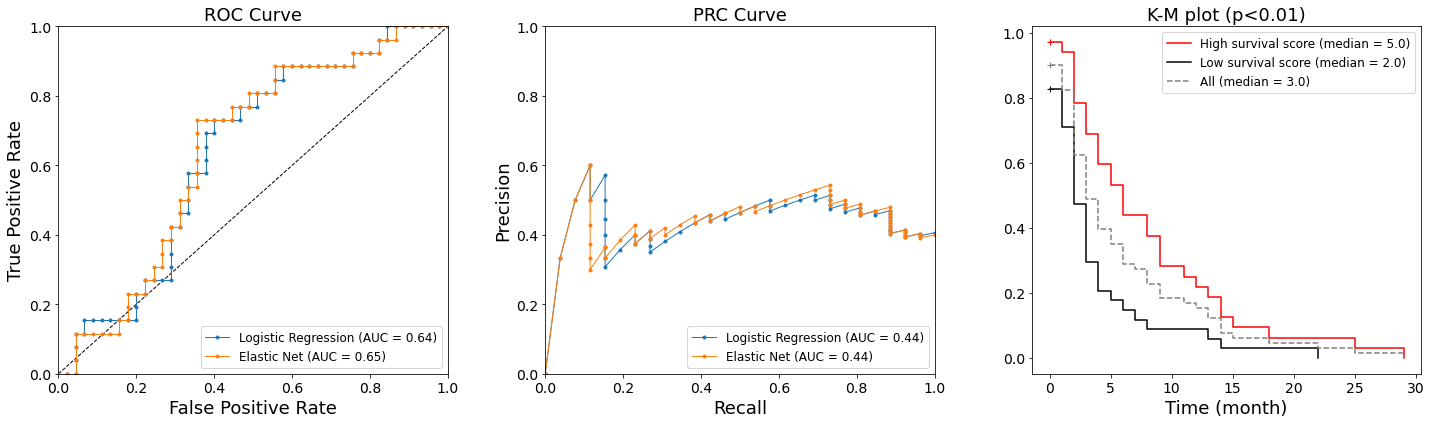

In [62]:
# make prediction
lr_estimator.fit(X_full_train, y_full_train['surv_getThres'])
lr_prediction = lr_estimator.predict_proba(X_test)[:, 1].tolist()

ml_estimator.fit(X_full_train, y_full_train['surv_getThres'])
ml_prediction = ml_estimator.predict_proba(X_test)[:, 1].tolist()

# Compute tpr and fpr for plotting ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(lr_prediction), drop_intermediate=False)
lr_roc_auc = auc(lr_fpr, lr_tpr)

ml_fpr, ml_tpr, _ = roc_curve(y_test['surv_getThres'], np.array(ml_prediction), drop_intermediate=False)
ml_roc_auc = auc(ml_fpr, ml_tpr)

# Compute precision and recall for plotting PRC curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test['surv_getThres'], np.array(lr_prediction))
lr_precision, lr_recall = lr_precision[:-1], lr_recall[:-1]
lr_prc_auc = auc(lr_recall, lr_precision)

ml_precision, ml_recall, _ = precision_recall_curve(y_test['surv_getThres'], np.array(ml_prediction))
ml_precision, ml_recall = ml_precision[:-1], ml_recall[:-1]
ml_prc_auc = auc(ml_recall, ml_precision)

# plot settings
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
lw = 1 # line width

# plot ROC curve
ax1.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--') # diagonal line
ax1.plot(lr_fpr, lr_tpr, marker='.', lw=lw, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
ax1.plot(ml_fpr, ml_tpr, marker='.', lw=lw, label='Elastic Net (AUC = %0.2f)' % ml_roc_auc)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xlabel('False Positive Rate', fontsize=18)
ax1.set_ylabel('True Positive Rate', fontsize=18)
ax1.set_title('ROC Curve', fontsize=18)
ax1.legend(loc="lower right", fontsize=12)

# plot PRC curve
ax2.plot(lr_recall, lr_precision, marker='.', lw=lw, label='Logistic Regression (AUC = %0.2f)' % lr_prc_auc)
ax2.plot(ml_recall, ml_precision, marker='.', lw=lw, label='Elastic Net (AUC = %0.2f)' % ml_prc_auc)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xlabel('Recall', fontsize=18)
ax2.set_ylabel('Precision', fontsize=18)
ax2.set_title('PRC Curve', fontsize=18)
ax2.legend(loc="lower right", fontsize=12)

# plot survival
kmf = KaplanMeierFitter()
kmf.fit(surv_highscore['surv_months'], surv_highscore['surv_event'], label='High survival score (median = %0.1f)' % np.median(surv_highscore['surv_months']))
kmf.plot(ax=ax3, color='r', show_censors=True, censor_styles={'ms': 6}, fontsize=14, ci_show=False)

kmf.fit(surv_lowscore['surv_months'], surv_lowscore['surv_event'], label='Low survival score (median = %0.1f)' % np.median(surv_lowscore['surv_months']))
kmf.plot(ax=ax3, color='k', show_censors=True, censor_styles={'ms': 6}, fontsize=14, ci_show=False)

kmf.fit(surv_data['surv_months'], surv_data['surv_event'], label='All (median = %0.1f)' % np.median(surv_data['surv_months']))
kmf.plot(ax=ax3, color='gray', linestyle='--', show_censors=True, censor_styles={'ms': 6}, fontsize=14, ci_show=False)

ax3.set_title('K-M plot ' + latex_p(surv_logrank._p_value[0]), fontsize=18)
ax3.set_xlabel('Time (month)', fontsize=18)
ax3.legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

# SHAP Value Analysis

  0%|          | 0/71 [00:00<?, ?it/s]

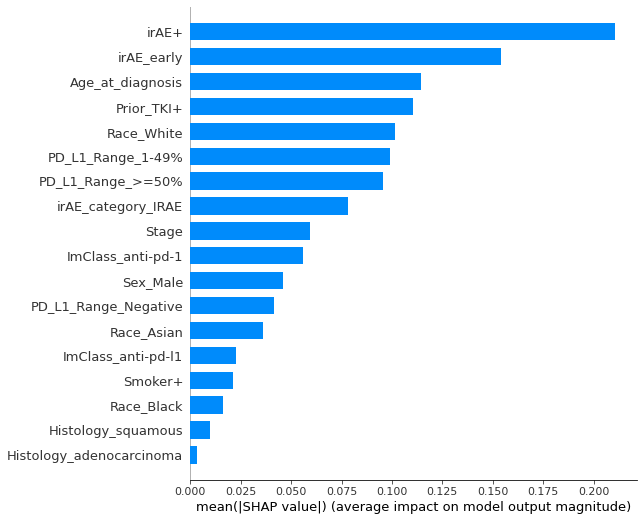

In [63]:
# run shap analysis
explainer = shap.KernelExplainer(ml_estimator.predict, X_test)
shap_values = explainer.shap_values(X_test)

# calculate overall feature importance
shap.summary_plot(shap_values, X_test, plot_type='bar')

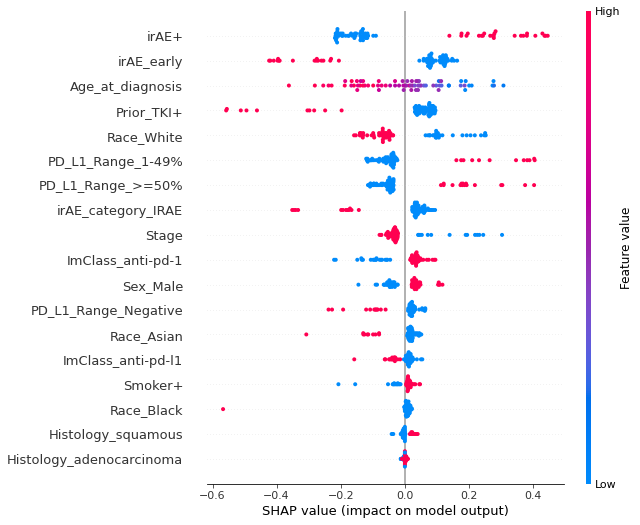

In [64]:
shap.summary_plot(shap_values, X_test, max_display=min(X_test.shape[1], 20), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)